In [1]:
using Pkg
venv_dir = (@__DIR__) * "/../../muc_venv"
Pkg.activate(venv_dir)

using Revise
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm, writedlm
using DataFrames
using CSV
using Interpolations
using PythonPlot
using PythonCall
mpl = pyimport("matplotlib")
pe = pyimport("matplotlib.patheffects")
using NaturallyUnitful

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

golden_ratio = (1+sqrt(5))/2
to_cm_ns = ustrip(unnatural(u"cm*ns^-1", 1))
GeV_to_ns = ustrip(unnatural(u"ns", 1*u"GeV^-1"))
ccms = ustrip(unnatural(u"cm*s^-1", 1))

FIGDIR = "./"

# make sure these match what the script has output
MG_RESULTS_DIR = "/home/aradick/Downloads/Madgraph/3_5_6/uR_dynamic/"
DIR_mumu_LR = "mumu_to_phiphi_LR/"
DIR_mumu_RL = "mumu_to_phiphi_RL/"
DIR_VV = "VV_to_phiphi/"

RUN_RESULTS_FILENAME = "run_info.csv"
SUMMARY_FILENAME = "diphi_summary.csv"
;

  Activating project at `~/Dropbox (University of Oregon)/research/flavorDM2/Aria/muc_venv`


In [2]:
includet(venv_dir*"/"*"LLP_utils.jl")
using .LLP_Utils
;

# Cross-Section Comparison

In [3]:
runs_pdf = get_runs_info(MG_RESULTS_DIR, DIR_mumu_LR, DIR_mumu_RL, DIR_VV)
runs_nopdf = LLP_Utils.nopdf_run_info(runs_pdf)
;

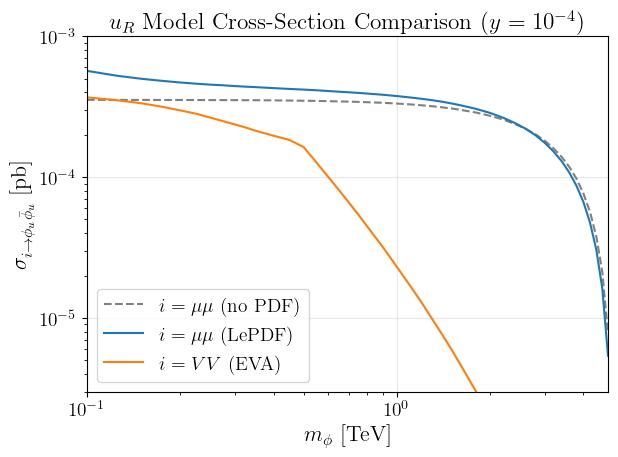

In [15]:
f = figure()
plot( 1e-3 .* runs_pdf.mphis, sum(runs_nopdf.xsecs[1:end-1,:];dims=1)[:],
      c="grey", ls="dashed", label=L"$i = \mu \mu$ (no PDF)" )
plot( 1e-3 .* runs_pdf.mphis, sum(runs_pdf.xsecs[1:end-1,:];dims=1)[:],
      c="tab:blue", label=L"$i = \mu \mu$ (LePDF)" )
plot( 1e-3 .* runs_pdf.mphis, runs_pdf.xsecs[end,:],
      c="tab:orange", label=L"$i = VV$ (EVA)" )
# plot( 1e-3 .* runs_pdf.mphis, sum(runs_pdf.xsecs;dims=1)[:],
#       c="k", label="Total" )
xlabel(L"$m_\phi$ [TeV]")
ylabel(L"$\sigma_{i \to \phi_u \bar{\phi}_u}$ [pb]")
xscale("log")
yscale("log")
xlim(1e-3*runs_pdf.mphis[1], 1e-3*runs_pdf.mphis[end])
ylim(3e-6, 1e-3)
grid(alpha=0.3)
title(L"$u_R$ Model Cross-Section Comparison ($y=10^{-4}$)")
legend(loc="lower left")
plotclose()
f.savefig("uR_xsec_mass_scan.pdf", bbox_inches="tight")
f

# Histograms

## 1D

In [4]:
function make_histograms_xsec(run_info::RunsInfo, lumi, mass_idxs; 
                              binsize=[0.2, 0.5,
                              ustrip(natural(6.0*u"cm*ns^-1"))],
                              fig_idx=1:3,
                              orient="vertical",
                              text=nothing)
    N_mphis = length(mass_idxs)

    labels = Vector{String}()
    for m in (1e-3 .* run_info.mphis[mass_idxs])
        push!(labels, L"$m_\phi = %$(round(m,sigdigits=4))$ TeV")
    end

    run_summaries = get_run_summaries(run_info, mass_idxs)
    
    N_events = length.(βγ.(run_summaries))

    stitle = L"$\phi_u$ Final States ($u$ Model)"
    xlabels = [L"\beta \gamma", L"\eta", L"$L/\tau_{\phi}$ [cm/ns]", L"\beta"]
    colors = ["tab:blue", "tab:orange", "tab:red", "tab:cyan"]
    colorms = ["tab:blue", "tab:orange", "tab:red"]
    linestyles = ["solid", "dashed"]
    sizes_v = [(6,5), (6,8), (6,11)]
    sizes_h = [(6,5), (10,5), (15,5)]

    if orient == "vertical"
        fig, axs = subplots(length(fig_idx), 1, figsize=sizes_v[length(fig_idx)])
        sheight = .98
    elseif orient == "horizontal"
        fig, axs = subplots(1, length(fig_idx), figsize=sizes_h[length(fig_idx)])
        sheight = .85
    end

    binmax_βγ = maximum(maximum.(βγ.(run_summaries)))
    βγ_bins = range(0, ceil(binmax_βγ/binsize[1])*binsize[1]; step=binsize[1])

    η_bins = range(-7.5, 7.5; step=binsize[2])
    
    binmax_Lτ = maximum(maximum.(Lτ.(run_summaries)))
    Lτ_bins = range(0, ceil(binmax_Lτ/binsize[3])*binsize[3]; step=binsize[3])

    beta_bins = 0.0:0.05:1.0

    binns = [βγ_bins, η_bins, Lτ_bins, beta_bins]
    binns_scaled = [βγ_bins, η_bins, ustrip.(unnatural.(u"cm*ns^-1", Lτ_bins)),
                    beta_bins]

    xmins = [0, -7.5, 0, 0]
    xmaxs = [βγ_bins[end], 7.5, ustrip(unnatural(u"cm*ns^-1", Lτ_bins[end])), 1]

    fns = [βγ, η, Lτ, β]

    if length(fig_idx) == 1
        axss = (axs,)
    else
        axss = axs
    end

    for (i, ax) in enumerate(axss)
        minN = zeros(Float64, N_mphis)
        maxN = zeros(Float64, N_mphis)

        binned_stuff = bin_data.(fns[fig_idx[i]].(run_summaries), (binns[fig_idx[i]],))
        scaled_stuff = xsec.(run_summaries) .* lumi .* binned_stuff ./ N_events

        N_expected = sum(scaled_stuff; dims=1)
        # println(sum.(N_expected))

        for j in eachindex(N_expected)
            minN[j] = minimum(N_expected[j][N_expected[j] .> 0])
            maxN[j] = maximum(N_expected[j])
            n = @. N_expected[j] + (N_expected[j] == 0)*1e-50 # trick to make stairs work
            ax.stairs(log10.(n), edges=binns_scaled[fig_idx[i]], 
                color=colorms[j], linestyle=linestyles[1])
        end

        # ylim_min = floor(log10(minimum(minN)))
        # ylim_max = ceil(log10(maximum(maxN)))

        ylim_min = -1
        ylim_max = 4

        ax.set_xlabel(xlabels[fig_idx[i]])
        ax.set_ylabel("\\# of Expected Events")

        ax.grid(alpha=0.3)

        ax.set_xlim((xmins[fig_idx[i]], xmaxs[fig_idx[i]]))
        ax.set_ylim((ylim_min, ylim_max))

        x_extent = xmaxs[fig_idx[i]]-xmins[fig_idx[i]]
        y_extent = ylim_max - ylim_min

        if y_extent <= 5
            yticks = ylim_min:ylim_max
        else
            yticks = ylim_min:2:ylim_max
        end
        yticklabels = [L"10^{%$(round(Int,x))}" for x in yticks]
        ax.set_yticks(yticks, yticklabels)

        ax.set_aspect(x_extent / (y_extent*golden_ratio), adjustable="box")

    end

    if length(fig_idx) == 1
        for i in eachindex(labels)
            axs.plot(0, Inf, lw=1., c=colors[i], label=labels[i])
        end

        handles, labels = axs.get_legend_handles_labels()

        axs.set_title(stitle)

        axs.legend(handles, labels, loc="lower right", fontsize=12)

        props = Dict("boxstyle"=>"round", "facecolor"=>"white", "alpha"=>1)
        axs.text(0.025, 0.95, text, transform=axs.transAxes, 
                fontsize=12, verticalalignment="top", horizontalalignment="left",
                bbox=props)
    else
        for i in eachindex(labels)
            axs[0].plot(0, Inf, lw=1., c=colors[i], label=labels[i])
        end

        handles, labels = axs[0].get_legend_handles_labels()

        # axs[0].set_title(L"$\mu^+ \mu^- \to \phi^+ \phi^-$ ($\ell_R$ Model)")
        fig.suptitle(stitle, y=sheight)

        fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=12)
    end

    tight_layout(rect=(0, 0.05, 1, 1))

    plotclose()
    return fig
end
;

In [20]:
println(findall(x -> x == 500.0, runs_pdf.mphis))
println(findall(x -> x == 1000.0, runs_pdf.mphis))
println(findall(x -> x == 4000.0, runs_pdf.mphis))

[14]
[22]
[40]


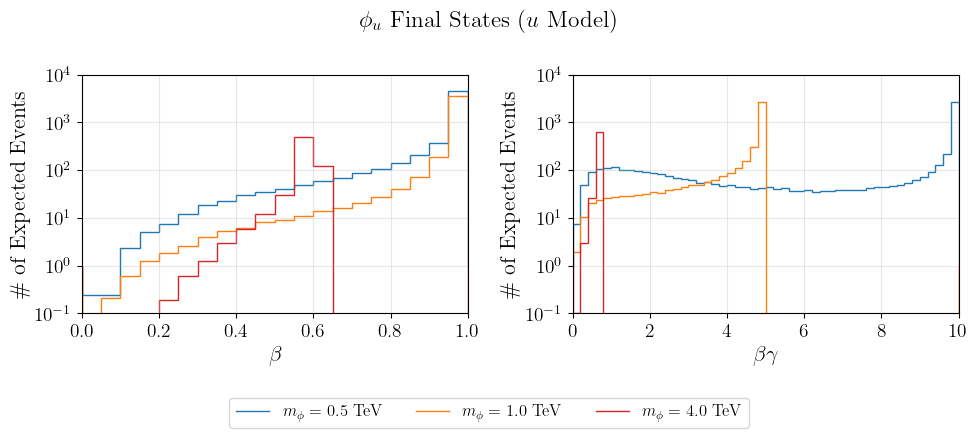

In [5]:
f1d_hist = make_histograms_xsec(runs_pdf, 10e6, [14,22,40]; fig_idx=[4,1], 
            orient="horizontal")
f1d_hist.savefig("uR_LLP_beta.pdf", bbox_inches="tight")
f1d_hist

## 2D Histogram $\beta \gamma$ vs $\eta$

In [11]:
function fbin(summary, βγ_range, η_range)
    Nevent = length(summary[1,:])
    βγ_test = βγ_range[1] .<= summary[2,:] .< βγ_range[2]
    η_test = η_range[1] .<= summary[3,:] .< η_range[2]
    res = sum(βγ_test .&& η_test)
    return res / Nevent
end

function bin_data_2d(rts_runs, lumi; binsize=[[0.05, 0.05, 0.05], 0.5])
    N_mphis = length(rts_runs.mphis)
    mphi_runs = get_run_with_summary.((rts_runs,), Vector(1:N_mphis))
    N_events = length(mphi_runs[1].mumu_summary[1,:])

    eachmax_βγ = [maximum(mphi_runs[j].mumu_summary[2,:]) for j in 1:N_mphis]
    eachmax2_βγ = [maximum(mphi_runs[j].vv_summary[2,:]) for j in 1:N_mphis]
    βγ_locs = Vector{Vector{Float64}}()

    η_bins = range(-5.5, 5.5; step=binsize[2])
    η_locs = (η_bins[2:end] .+ η_bins[1:end-1])./2

    η_s = [[η_bins[i], η_bins[i+1]] for i in 1:(length(η_bins)-1)]

    res = Vector{Matrix{Float64}}()

    for i in 1:N_mphis
        binmax_βγ = max(eachmax_βγ[i], eachmax2_βγ[i])
        βγ_bins = range(0, ceil(binmax_βγ/binsize[1][i])*binsize[1][i]; 
                    step=binsize[1][i])
        push!(βγ_locs, (βγ_bins[2:end] .+ βγ_bins[1:end-1])./2)

        βγ_s = [[βγ_bins[i], βγ_bins[i+1]] for i in 1:(length(βγ_bins)-1)]

        frac_mumu = fbin.((mphi_runs[i].mumu_summary,), βγ_s, η_s')
        frac_vv = fbin.((mphi_runs[i].vv_summary,), βγ_s, η_s')

        n_mumu = @. mphi_runs[i].mumu_xsec * lumi * frac_mumu
        n_vv = @. mphi_runs[i].vv_xsec * lumi * frac_vv

        push!(res, n_mumu .+ n_vv)
    end
    return (N_events=res, ηs=η_locs, βγs=βγ_locs, rts=rts_runs.rts,
            lumi=lumi, mphis=(1e-3 .* rts_runs.mphis))
end

function make_2d_hist(binned_data)
    title = L"$\sqrt{s} = %$(1e-3*binned_data.rts)$ TeV, $\mathcal{L} = %$(binned_data.lumi*1e-6)$ ab$^{-1}$"
    labels = Vector{String}()

    for m in binned_data.mphis
        push!(labels, L"$m_\phi = %$(round(m,digits=1))$ TeV")
    end

    xlabels = [L"\beta \gamma", L"\eta"]
    colors = ["tab:blue", "tab:orange", "tab:red"]
    linestyles = ["solid", "dashed"]

    fig, axs = subplots(3, 1, figsize=(5, 10))

    min_N = 1e-7
    max_N = 1e3

    Lτ_levels = 10 .^ range(log10(.2), log10(to_cm_ns*maximum(maximum.(binned_data.βγs))), 8)
    formatter(l) = L"%$(round(l, sigdigits=2))"

    for (i, a) in enumerate(axs)
        a.set_xlim(-5.5, 5.5)
        a.set_ylim(0, binned_data.βγs[i][end] + 
            (binned_data.βγs[i][2]-binned_data.βγs[i][1])/2)
            
        g = a.pcolormesh(binned_data.ηs, binned_data.βγs[i], 
            binned_data.N_events[i], norm="log", cmap="inferno",
            vmin=min_N, vmax=max_N)

        βγ_max = binned_data.βγs[i][end] + (binned_data.βγs[i][2]-binned_data.βγs[i][1])/2
        βγ_Lτ = range(0, βγ_max, 50)
        ηs_Lτ = range(-5.5, 5.5, 50)
        Lτs = @. to_cm_ns * βγ_Lτ / cosh(ηs_Lτ')
        C = a.contour(ηs_Lτ, βγ_Lτ, Lτs,
                    levels=Lτ_levels, colors="black")

        txts = clabel(C, Lτ_levels, colors="k", fmt=formatter, 
            use_clabeltext=true, inline=true)#, fontsize=16)
        
        for t in txts
            t.set_path_effects([pe.withStroke(linewidth=3, foreground="w")])
        end

        a.set_xlabel(L"\eta")
        a.set_ylabel(L"\beta \gamma")

        a.set_title(labels[i])

        a.grid(alpha=0.3)

        fig.colorbar(g)
    end

    fig.suptitle(title)

    plotclose()
    return fig
end
;

In [12]:
rts3_binned = bin_data_2d(rts3_runs, 1e6);

In [13]:
rts10_binned = bin_data_2d(rts10_runs, 10e6; binsize=[[0.2, 0.2, 0.05], 0.5]);

In [ ]:
f2d_3 = make_2d_hist(rts3_binned)
f2d_3.savefig(FIGDIR*"2d_betagamma_eta_rts=3.pdf")
f2d_3

In [ ]:
f2d = make_2d_hist(rts10_binned)
f2d.savefig(FIGDIR*"2d_betagamma_eta_rts=10.pdf", bbox_inches="tight")
f2d

## 2D Histogram $L/\tau_\phi$ vs $\eta$

In [17]:
function fbin_2(summary, Lτ_range, η_range)
    Nevent = length(summary[1,:])
    Lτ = summary[2,:] ./ cosh.(summary[3,:])
    Lτ_test = Lτ_range[1] .<= Lτ .< Lτ_range[2]
    η_test = η_range[1] .<= summary[3,:] .< η_range[2]
    res = sum(Lτ_test .&& η_test)
    return res / Nevent
end

function bin_data_2d_Lτ(rts_runs, lumi; binsize=[[0.05, 0.05, 0.05],.5])
    N_mphis = length(rts_runs.mphis)
    mphi_runs = get_run_with_summary.((rts_runs,), Vector(1:N_mphis))
    N_events = length(mphi_runs[1].mumu_summary[1,:])

    mumu_Lτ = [mphi_runs[j].mumu_summary[2,:] ./ 
                cosh.(mphi_runs[j].mumu_summary[3,:]) for j in 1:N_mphis]
    vv_Lτ = [mphi_runs[j].vv_summary[2,:] ./ 
            cosh.(mphi_runs[j].vv_summary[3,:]) for j in 1:N_mphis]

    eachmax_βγ = [maximum(mphi_runs[j].mumu_summary[2,:]) for j in 1:N_mphis]
    eachmax2_βγ = [maximum(mphi_runs[j].vv_summary[2,:]) for j in 1:N_mphis]
    Lτ_locs = Vector{Vector{Float64}}()

    η_bins = range(-5.5, 5.5; step=binsize[2])
    η_locs = (η_bins[2:end] .+ η_bins[1:end-1])./2
    η_s = [[η_bins[i], η_bins[i+1]] for i in 1:(length(η_bins)-1)]

    res = Vector{Matrix{Float64}}()

    for i in 1:N_mphis
        binmax_βγ = max(eachmax_βγ[i], eachmax2_βγ[i])
        βγ_bins = range(0, ceil(binmax_βγ/binsize[1][i])*binsize[1][i]; 
                    step=binsize[1][i])
        push!(Lτ_locs, (βγ_bins[2:end] .+ βγ_bins[1:end-1])./2)

        Lτ_s = [[βγ_bins[i], βγ_bins[i+1]] for i in 1:(length(βγ_bins)-1)]

        frac_mumu = fbin_2.((mphi_runs[i].mumu_summary,), Lτ_s, η_s')
        frac_vv = fbin_2.((mphi_runs[i].vv_summary,), Lτ_s, η_s')

        n_mumu = @. mphi_runs[i].mumu_xsec * lumi * frac_mumu
        n_vv = @. mphi_runs[i].vv_xsec * lumi * frac_vv

        push!(res, n_mumu .+ n_vv)
    end
    return (N_events=res, ηs=η_locs, Lτs=Lτ_locs, rts=rts_runs.rts,
            lumi=lumi, mphis=(1e-3 .* rts_runs.mphis))
end

function make_2d_hist_Lτ(binned_data)
    title = L"$\sqrt{s} = %$(1e-3*binned_data.rts)$ TeV, $\mathcal{L} = %$(binned_data.lumi*1e-6)$ ab$^{-1}$"
    labels = Vector{String}()

    for m in binned_data.mphis
        push!(labels, L"$m_\phi = %$(round(m,digits=1))$ TeV")
    end

    fig, axs = subplots(3, 1, figsize=(5, 10))

    min_N = 1e-7
    max_N = 1e3

    for (i, a) in enumerate(axs)
        Lτ_scaled = ustrip.(unnatural.(u"cm*ns^-1", binned_data.Lτs[i]))

        g = a.pcolormesh(binned_data.ηs, Lτ_scaled, 
            binned_data.N_events[i][:,:], norm="log", 
            vmin=min_N, vmax=max_N, cmap="inferno")

        a.set_xlabel(L"\eta")
        a.set_ylabel(L"$L/\tau_\phi$ [cm/ns]")

        a.set_xlim(-5.5, 5.5)
        a.set_ylim(0, ceil(maximum(Lτ_scaled)))

        a.set_title(labels[i])

        a.grid(alpha=0.3)

        fig.colorbar(g)
    end

    fig.suptitle(title)

    plotclose()
    return fig
end
;

In [18]:
rts3_binned_Lτ = bin_data_2d_Lτ(rts3_runs, 1e6);
rts10_binned_Lτ = bin_data_2d_Lτ(rts10_runs, 10e6; binsize=[[0.2, 0.2, 0.05], 0.5]);

In [ ]:
f2d_Lτ_3 = make_2d_hist_Lτ(rts3_binned_Lτ)
f2d_Lτ_3.savefig(FIGDIR*"Ltau_2d_rts=3.pdf")
f2d_Lτ_3

In [ ]:
f2d_Lτ_10 = make_2d_hist_Lτ(rts10_binned_Lτ)
f2d_Lτ_10.savefig(FIGDIR*"Ltau_2d_rts=10.pdf")
f2d_Lτ_10

## 2D Histogram $L/\tau_\phi$ vs $\beta \gamma$

In [21]:
function fbin_3(summary, Lτ_range, βγ_range)
    Nevent = length(summary[1,:])
    Lτ = summary[2,:] ./ cosh.(summary[3,:])
    Lτ_test = Lτ_range[1] .<= Lτ .< Lτ_range[2]
    βγ_test = βγ_range[1] .<= summary[2,:] .< βγ_range[2]
    res = sum(Lτ_test .&& βγ_test)
    return res / Nevent
end

function bin_data_2d_βγ_Lτ(rts_runs, lumi; binsize=[0.05, 0.05, 0.05])
    N_mphis = length(rts_runs.mphis)
    mphi_runs = get_run_with_summary.((rts_runs,), Vector(1:N_mphis))
    N_events = length(mphi_runs[1].mumu_summary[1,:])

    eachmax_βγ = [maximum(mphi_runs[j].mumu_summary[2,:]) for j in 1:N_mphis]
    eachmax2_βγ = [maximum(mphi_runs[j].vv_summary[2,:]) for j in 1:N_mphis]
    βγ_locs = Vector{Vector{Float64}}()

    res = Vector{Matrix{Float64}}()

    for i in 1:N_mphis
        binmax_βγ = max(eachmax_βγ[i], eachmax2_βγ[i])
        βγ_bins = range(0, ceil(binmax_βγ/binsize[i])*binsize[i]; 
                    step=binsize[i])
        push!(βγ_locs, (βγ_bins[2:end] .+ βγ_bins[1:end-1])./2)

        βγ_s = [[βγ_bins[i], βγ_bins[i+1]] for i in 1:(length(βγ_bins)-1)]

        frac_mumu = fbin_3.((mphi_runs[i].mumu_summary,), βγ_s, βγ_s')
        frac_vv = fbin_3.((mphi_runs[i].vv_summary,), βγ_s, βγ_s')

        n_mumu = @. mphi_runs[i].mumu_xsec * lumi * frac_mumu
        n_vv = @. mphi_runs[i].vv_xsec * lumi * frac_vv

        push!(res, n_mumu .+ n_vv)
    end
    return (N_events=res, βγs=βγ_locs, Lτs=βγ_locs, rts=rts_runs.rts,
            lumi=lumi, mphis=(1e-3 .* rts_runs.mphis))
end

function make_2d_hist_βγ_Lτ(binned_data)
    title = L"$\sqrt{s} = %$(1e-3*binned_data.rts)$ TeV, $\mathcal{L} = %$(binned_data.lumi*1e-6)$ ab$^{-1}$"
    labels = Vector{String}()

    for m in binned_data.mphis
        push!(labels, L"$m_\phi = %$(round(m,digits=1))$ TeV")
    end

    fig, axs = subplots(3, 1, figsize=(5, 10))

    min_N = 1e-7
    max_N = 1e3

    for (i, a) in enumerate(axs)
        Lτ_scaled = ustrip.(unnatural.(u"cm*ns^-1", binned_data.Lτs[i]))

        g = a.pcolormesh(binned_data.βγs[i], Lτ_scaled, 
            binned_data.N_events[i][:,:], norm="log", 
            vmin=min_N, vmax=max_N, cmap="inferno")

        a.set_xlabel(L"\beta \gamma")
        a.set_ylabel(L"$L/\tau_\phi$ [cm/ns]")

        # a.set_ylim(0, ceil(maximum(Lτ_scaled)))

        a.set_title(labels[i])

        a.grid(alpha=0.3)

        fig.colorbar(g)
    end

    fig.suptitle(title)

    plotclose()
    return fig
end
;

In [22]:
rts3_binned_βγ_Lτ = bin_data_2d_βγ_Lτ(rts3_runs, 1e6);
rts10_binned_βγ_Lτ = bin_data_2d_βγ_Lτ(rts10_runs, 10e6; binsize=[0.2,0.2,0.05]);

In [ ]:
f2d_Lτ_βγ_3 = make_2d_hist_βγ_Lτ(rts3_binned_βγ_Lτ)
f2d_Lτ_βγ_3.savefig(FIGDIR*"Ltau_vs_betagamma_rts=3.pdf")
f2d_Lτ_βγ_3

In [ ]:
f2d_Lτ_βγ_10 = make_2d_hist_βγ_Lτ(rts10_binned_βγ_Lτ)
f2d_Lτ_βγ_10.savefig(FIGDIR*"Ltau_vs_betagamma_rts=10.pdf")
f2d_Lτ_βγ_10

# # of expected events decaying in each detector subsystem

In [5]:
run_infos = get_runs_info(DIR_SCAN_NEW, DIR_mumu_LR, DIR_mumu_RL, DIR_VV)
;

In [18]:
function mχ_upper_bound(mφ)
    min(LFDM_Boltz.Mstar_s(mφ/25)/LFDM_Boltz.find_yφf(mφ), mφ)
end

mφ_for_bounds = 10 .^ range(log10(100), 
                                log10(10000/2), 1000)
mχ_upper = mχ_upper_bound.(mφ_for_bounds)
;

In [19]:
Mphis_hscp = 10 .^ range(1.9, log10(520), 50)
mχ_hscp = LFDM_Boltz.mχ_life.(1e-9, Mphis_hscp)
mχ_hscp_upper = mχ_upper_bound.(Mphis_hscp)
;

In [20]:
import DelimitedFiles: readdlm

seR_dir = "data/selectron_bounds/"

se_lo_data = readdlm(seR_dir * "seR_bounds_lower.csv", ',')
se_hi_data = readdlm(seR_dir * "seR_bounds_upper.csv", ',')

se_lo_func = linear_interpolation(se_lo_data[:,1], se_lo_data[:,2] .* 1e-9, extrapolation_bc=Line())
se_hi_func = linear_interpolation(se_hi_data[:,1], se_hi_data[:,2] .* 1e-9, extrapolation_bc=Line())

seR_mphis = 10 .^ range(1.9, log10(584), 100)

seR_lo_τφ = se_lo_func.(seR_mphis)
seR_hi_τφ = se_hi_func.(seR_mphis)

seR_lo_mχ = LFDM_Boltz.mχ_life.(se_lo_func.(seR_mphis), seR_mphis)
seR_hi_mχ = LFDM_Boltz.mχ_life.(se_hi_func.(seR_mphis), seR_mphis)
;

In [29]:
function Lzτ(run_summary::RunSummary)
    βγ(run_summary) .* tanh.(η(run_summary))
end

function events_in_detector_1(summary::RunSummary, lumi, tauphi, R_cm, Z_cm)
    pref = summary.xsec * lumi / N_events(summary)

    L = Lτ(summary).*tauphi.*to_cm_ns
    Lz = Lzτ(summary).*tauphi.*to_cm_ns
    
    return pref*count((R_cm[1] .< L .< R_cm[2]) .&& (Lz .< Z_cm))
end

function events_in_detector_1η(summary, lumi, tauphi, R_cm, η_bound)
    pref = summary.xsec * lumi / N_events(summary)

    L = Lτ(summary).*tauphi.*to_cm_ns
    etas = eta(summary)

    N_passes = count((R_cm[1] .< L .< R_cm[2]) .&& (abs.(etas) .< η_bound))
    
    return pref*N_passes
end

function events_in_detector(run_info::RunsInfo, lumi, τφs, R_cm, Z_cm)
    N_mphi = length(run_info.mphis)
    N_mchi = length(τφs[1,:])

    res = zeros(Float64, (N_mphi, N_mchi))

    for i in 1:N_mphi
        summary = get_run_summaries(run_info, i)
        for j in 1:N_mchi
            if mchis[j] >= run_info.mphis[i]
                res[i,j] = NaN
            else
                N_expecteds = events_in_detector_1.(summary, lumi, τφs[i,j], (R_cm,), Z_cm)
                res[i,j] = sum(N_expecteds)
            end
        end
    end
    return res
end

function events_in_detector_η(run_info::RunsInfo, lumi, τφs, R_cm, η_bound)
    N_mphi = length(run_info.mphis)
    N_mchi = length(τφs[1,:])

    res = zeros(Float64, (N_mphi, N_mchi))

    for i in 1:N_mphi
        summary = get_run_summaries(run_info, i)
        for j in 1:N_mchi
            if mchis[j] >= run_info.mphis[i]
                res[i,j] = NaN
            else
                N_expecteds = events_in_detector_1η.(summary, lumi, τφs[i,j], (R_cm,), η_bound)
                res[i,j] = sum(N_expecteds)
            end
        end
    end
    return res
end

function events_in_detector(run_info::RunsInfo, lumi, mchis)
    detector_Rs = [[3, 10.4], [12.7, 55.4], [81.9, 148.6], [150, 170.2], 
                    [174, 333], [348.3, 429.0], [446.1, 645.0], [645.0, Inf]]
    detector_Zs = [65, (69.2+48.2)/2, 124.9, 221.0, 221.0, 412.9, 417.9, Inf]

    det_labs = ["in Vertex Detector", "in Inner Tracker", "in Outer Tracker", "in ECAL",
                "in HCAL", "in Solenoid", "in Muon Detector", "Outside"]

    N_exp = zeros(Float64, (length(detector_Rs), length(run_info.mphis), 
                    length(mchis)))
    
    τφs = lifetimes(run_info.mphis, mchis).*1e9
    
    for i in 1:(length(detector_Rs)-1)
        N_exp[i,:,:] = events_in_detector(run_info, lumi, τφs, detector_Rs[i],
            detector_Zs[i])
    end

    N_exp[end,:,:] = events_in_detector_η(run_info, lumi, τφs, 
                        detector_Rs[end], 0.61)

    return (N_exp=N_exp, rts=10e3, lumi=lumi, mphis=run_info.mphis,
            mchis=mchis, labels=det_labs)
end
;

In [22]:
function events_in_detector_τφ(rts_runs, lumi, τφs, R_cm, Z_cm)
    N_events = 200000
    N_mphi = length(rts_runs.mphis)
    N_τφ = length(τφs)

    res = zeros(Float64, (N_mphi, N_τφ))

    for i in 1:N_mphi
        summary = get_run_summaries(rts_runs, i)
        for j in 1:N_τφ
            N_expecteds = events_in_detector_1.(
                            summary, lumi, τφs[j], (R_cm,), Z_cm
                            )
            res[i,j] = sum(N_expecteds)
        end
    end
    return res
end

function events_in_detector_η_τφ(rts_runs, lumi, τφs, R_cm, η)
    N_events = 200000
    N_mphi = length(rts_runs.mphis)
    N_τφ = length(τφs)

    res = zeros(Float64, (N_mphi, N_τφ))

    for i in 1:N_mphi
        summary = get_run_summaries(rts_runs, i)
        for j in 1:N_τφ
            N_expecteds = events_in_detector_1η.(
                            summary, lumi, τφs[j], (R_cm,), η
                            )
            res[i,j] = sum(N_expecteds)
        end
    end
    return res
end

function events_in_detector_τφ(rts_runs, lumi, τφs_ns)
    detector_Rs = [[3, 10.4], [12.7, 55.4], [81.9, 148.6], [150, 170.2], 
                    [174, 333], [348.3, 429.0], [446.1, 645.0], [645.0, Inf]]
    detector_Zs = [65, (69.2+48.2)/2, 124.9, 221.0, 221.0, 412.9, 417.9, Inf]

    det_labs = ["in Vertex Detector", "in Inner Tracker", "in Outer Tracker", "in ECAL",
                "in HCAL", "in Solenoid", "in Muon Detector", "Outside"]

    N_exp = zeros(Float64, (length(detector_Rs), length(rts_runs.mphis), 
                    length(τφs_ns)))
    
    for i in 1:(length(detector_Rs)-1)
        N_exp[i,:,:] = events_in_detector_τφ(rts_runs, lumi, τφs_ns, detector_Rs[i],
            detector_Zs[i])
    end

    N_exp[end,:,:] = events_in_detector_η_τφ(rts_runs, lumi, τφs_ns, 
                        detector_Rs[end], 0.61)

    return (N_exp=N_exp, rts=10e3, lumi=lumi, mphis=rts_runs.mphis,
            tauphis=τφs_ns, labels=det_labs)
end

function eid_τφ_2(rts_runs, lumi, τφs_ns)
    detector_Rs = [[3, 10.4], [12.7, 55.4], [81.9, 148.6], [150, 170.2], 
                    [174, 333], [348.3, 429.0], [446.1, 645.0], [645.0, Inf]]
    detector_Zs = [65, (69.2+48.2)/2, 124.9, 221.0, 221.0, 412.9, 417.9, Inf]

    det_labs = ["in Vertex Detector", "in Inner Tracker", "in Outer Tracker", "in ECAL",
                "in HCAL", "in Solenoid", "in Muon Detector", "Outside"]

    N_exp = zeros(Float64, (length(detector_Rs), length(rts_runs.mphis), 
                    length(τφs_ns)))
    
    for i in 1:(length(detector_Rs)-1)
        N_exp[i,:,:] = events_in_detector_τφ(rts_runs, lumi, τφs_ns, detector_Rs[i],
            detector_Zs[i])
    end

    N_exp[end,:,:] = events_in_detector_η_τφ(rts_runs, lumi, τφs_ns, 
                        detector_Rs[end], 0.61)

    return (N_exp=N_exp, rts=10e3, lumi=lumi, mphis=rts_runs.mphis,
            tauphis=τφs_ns, labels=det_labs)
end
;

In [23]:
function make_money(events_in_detector)
    eid = events_in_detector
    title = L"Number of Expected Events ($\ell_R$ Model)"

    fig, axs = subplots(4,2,figsize=(10,12))

    mphi_plot = 10 .^ range(log10(eid.mphis[1]), log10(eid.mphis[end]), 100)
    mchi_plot = 10 .^ range(log10(eid.mchis[1]), log10(eid.mchis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:3.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    idx = 1
    for ax in axs
        for a in ax
            q = eid.N_exp[idx,:,:]

            g = a.pcolormesh(eid.mchis, eid.mphis, log10.(q), norm=norm,
                            cmap=cmap)
            a.fill_betweenx(mφ_for_bounds, mχ_upper, 1e4, color="gainsboro", 
                            zorder=2)

            a.fill_betweenx(Mphis_hscp, mχ_hscp, mχ_hscp_upper, 
                        edgecolor="xkcd:neon pink", facecolor="none")
            
            a.fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, edgecolor="xkcd:neon green",
                            facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            a.set_xscale("log")
            a.set_yscale("log")
            a.set_xlim(eid.mchis[1], eid.mchis[end])
            a.set_ylim(1e2, eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_xlabel(L"$m_\chi$ [GeV]")
            a.set_ylabel(L"$m_\phi$ [GeV]")

            idx += 1
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end

function make_money_max(events_in_detector)
    eid = events_in_detector

    cmap = mpl.cm.Purples
    bounds = -5.0:2.0:5.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")

    fig = figure(figsize=(8,5))

    q = maximum(eid.N_exp, dims=1)[1,:,:]

    g = pcolormesh(eid.mchis, eid.mphis, log10.(q), norm=norm, cmap=cmap)
    fill_betweenx(mφ_for_bounds, mχ_upper, 5e3, color="gainsboro", zorder=2)

    fill_betweenx(Mphis_hscp, mχ_hscp, mχ_hscp_upper, 
                        edgecolor="xkcd:neon pink", facecolor="none")
            
    fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, edgecolor="xkcd:neon green",
                    facecolor="none")
                    
    xscale("log")
    yscale("log")
    xlim(eid.mchis[1], eid.mchis[end])
    ylim(1e2, eid.rts/2)

    formatter(l) = L"10^{ %$(Int(l)) }"
    cbar = colorbar(g)
    cbar.ax.set_yticklabels(formatter.(bounds))

    title(L"$\sqrt{s} = %$(1e-3*eid.rts)$ TeV, $\mathcal{L} = %$(eid.lumi*1e-6)$ ab$^{-1}$")
    xlabel(L"$m_\chi$ [GeV]")
    ylabel(L"$m_\phi$ [GeV]")

    plotclose()

    return fig
end

function make_money_2(events_in_detector)
    eid = events_in_detector
    title = L"Number of Expected Events ($\sqrt{s} = %$(1e-3*eid.rts)$ TeV, $\mathcal{L} = %$(eid.lumi*1e-6)$ ab$^{-1}$)"

    fig, axs = subplots(2,4,figsize=(20,7))

    mphi_plot = 10 .^ range(log10(eid.mphis[1]), log10(eid.mphis[end]), 100)
    mchi_plot = 10 .^ range(log10(eid.mchis[1]), log10(eid.mchis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -5.0:2.0:5.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    idx = 1
    for ax in axs
        for a in ax
            q = eid.N_exp[idx,:,:]

            g = a.pcolormesh(eid.mchis, eid.mphis, log10.(q), norm=norm,
                            cmap=cmap)
            a.fill_betweenx(mφ_for_bounds, mχ_upper, 1e4, color="gainsboro", 
                            zorder=2)

            a.fill_betweenx(Mphis_hscp, mχ_hscp, mχ_hscp_upper, 
                        edgecolor="xkcd:neon pink", facecolor="none")
            
            a.fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, edgecolor="xkcd:neon green",
                            facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            a.set_xscale("log")
            a.set_yscale("log")
            a.set_xlim(eid.mchis[1], eid.mchis[end])
            a.set_ylim(1e2, eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_xlabel(L"$m_\chi$ [GeV]")
            a.set_ylabel(L"$m_\phi$ [GeV]")

            idx += 1
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end
;

In [27]:
mchis = 10 .^ range(-5, log10(3.5e3), 50);

In [13]:
eid3 = events_in_detector(rts3_runs, 1e6, mchis);

In [30]:
eid = events_in_detector(run_infos, 10e6, mchis);

In [ ]:
f_money = make_money(eid3)
f_money.savefig(FIGDIR*"decays_mphi_mchi_rts3.pdf", bbox_inches="tight")
f_money

In [ ]:
f_money10 = make_money(eid)
# f_money10.savefig(FIGDIR*"ellR_LLP_detector_events.pdf", bbox_inches="tight")
f_money10

In [ ]:
f_money10 = make_money_2(eid10)
f_money10.savefig(FIGDIR*"decays_2_mphi_mchi_rts=10.pdf", bbox_inches="tight")
f_money10

In [ ]:
f_mm = make_money_max(eid3)
f_mm.savefig(FIGDIR*"decays_max_rts3.pdf")
f_mm

In [ ]:
f_mm = make_money_max(eid10)
f_mm.savefig(FIGDIR*"decays_max_rts10.pdf")
f_mm

In [24]:
function make_money_τφ(events_in_detector)
    eid = events_in_detector
    title = L"Number of Expected Events ($\ell_R$ Model)"

    fig, axs = subplots(4,2,figsize=(10,12))

    mphi_plot = 10 .^ range(log10(eid.mphis[1]), log10(eid.mphis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:3.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    idx = 1
    for ax in axs
        for a in ax
            q = eid.N_exp[idx,:,:]'

            g = a.pcolormesh(1e-3 .* eid.mphis, eid.tauphis, log10.(q), norm=norm,
                            cmap=cmap)

            a.fill_between(1e-3 .* Mphis_hscp, 1.0, 1e15, edgecolor="xkcd:neon pink", facecolor="none")
            
            a.fill_between(1e-3 .* seR_mphis, 1e9*seR_lo_τφ, 1e9*seR_hi_τφ, edgecolor="xkcd:neon green",
                            facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            # a.set_xscale("log")
            a.set_yscale("log")
            a.set_ylim(eid.tauphis[1], eid.tauphis[end])
            a.set_xlim(1e-3 .* 1e2, 1e-3 .* eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_ylabel(L"$\tau_\phi$ [ns]")
            a.set_xlabel(L"$m_\phi$ [TeV]")

            a.grid(alpha=0.3)

            idx += 1
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end

function make_money_max_τφ(events_in_detector)
    eid = events_in_detector

    cmap = mpl.cm.Purples
    bounds = -5.0:2.0:5.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")

    fig = figure(figsize=(8,5))

    q = maximum(eid.N_exp, dims=1)[1,:,:]'

    g = pcolormesh(eid.mphis, eid.tauphis, log10.(q), norm=norm, cmap=cmap)

    fill_between(Mphis_hscp, 1.0, 1e15, edgecolor="xkcd:neon pink", facecolor="none")
            
    fill_between(seR_mphis, 1e9*seR_lo_τφ, 1e9*seR_hi_τφ, edgecolor="xkcd:neon green",
                    facecolor="none")
                    
    xscale("log")
    yscale("log")
    ylim(eid.tauphis[1], eid.tauphis[end])
    xlim(1e2, eid.rts/2)

    formatter(l) = L"10^{ %$(Int(l)) }"
    cbar = colorbar(g)
    cbar.ax.set_yticklabels(formatter.(bounds))

    title(L"$\sqrt{s} = %$(1e-3*eid.rts)$ TeV, $\mathcal{L} = %$(eid.lumi*1e-6)$ ab$^{-1}$")
    xlabel(L"$m_\phi$ [GeV]")
    ylabel(L"$\tau_\phi$ [ns]")

    plotclose()

    return fig
end
;

In [25]:
tauphis_money = 10 .^ range(-3, 4, 50)
eid10_τφ = events_in_detector_τφ(run_infos, 10e6, tauphis_money);

In [32]:
eid3_τφ = events_in_detector_τφ(rts3_runs, 1e6, tauphis_money);

In [ ]:
fm3_τφ = make_money_τφ(eid3_τφ)
fm3_τφ.savefig(FIGDIR*"decays_mphi_tauphi_rts3.pdf", bbox_inches="tight")
fm3_τφ

In [ ]:
fm10_τφ = make_money_τφ(eid10_τφ)
# fm10_τφ.savefig(FIGDIR*"ellR_decays_mphi_tauphi.pdf", bbox_inches="tight")
fm10_τφ

In [ ]:
fmm3_τφ = make_money_max_τφ(eid3_τφ)
fmm3_τφ.savefig(FIGDIR*"decays_max_tauphi_rts3.pdf", bbox_inches="tight")
fmm3_τφ

In [ ]:
fmm10_τφ = make_money_max_τφ(eid10_τφ)
fmm10_τφ.savefig(FIGDIR*"decays_max_tauphi_rts10.pdf", bbox_inches="tight")
fmm10_τφ

# MIP Comparison

In [28]:
function Δt_mip(summary::RunSummary, R_cm)
    return R_cm .* cosh.(eta(summary)) .*(1 ./ beta(summary) .- 1) ./ to_cm_ns
end

function make_Δt_hist(run_info::RunsInfo, lumi, mass_idxs; R_cm=446.1, log_binsize=.1)
    N_mphis = length(run_info.mphis[mass_idxs])

    labels = Vector{String}()
    for m in (1e-3 .* run_info.mphis[mass_idxs])
        push!(labels, L"$m_\phi = %$(round(m,sigdigits=4))$ TeV")
    end

    run_summaries = get_run_summaries(run_info, mass_idxs)
    
    N_events = length.(βγ.(run_summaries))

    colors = ["tab:blue", "tab:orange", "tab:red"]
    linestyles = ["solid", "dashed"]

    fig = figure(figsize=(5,5))
    ax = gca()

    Δt_vals = Δt_mip.(run_summaries, R_cm)
    
    binmin_Δt = minimum(minimum.(Δt_vals))
    binmax_Δt = maximum(maximum.(Δt_vals))

    min_Δt = floor(log10(binmin_Δt)/log_binsize)*log_binsize
    # max_Δt = ceil(log10(binmax_Δt)/log_binsize)*log_binsize
    max_Δt = 3

    Δt_bins = 10 .^ range(min_Δt, max_Δt; step=log_binsize)

    minN = zeros(Float64, N_mphis)
    maxN = zeros(Float64, N_mphis)

    binned_stuff = bin_data.(Δt_vals, (Δt_bins,))
    scaled_stuff = xsec.(run_summaries) .* lumi .* binned_stuff ./ N_events

    N_expected = sum(scaled_stuff; dims=1)

    for j in eachindex(N_expected)
        minN[j] = minimum(N_expected[j][N_expected[j] .> 0])
        maxN[j] = maximum(N_expected[j])
        n = @. N_expected[j] + (N_expected[j] == 0)*1e-50 # trick to make stairs work
        ax.stairs(log10.(n), edges=log10.(Δt_bins), 
            color=colors[j], linestyle=linestyles[1], label=labels[j])
    end

    ylim_min = floor(log10(minimum(minN)))
    ylim_max = ceil(log10(maximum(maxN)))

    # a.set_yscale("log")

    ax.set_xlabel(L"$\Delta t$ [ns]")
    ax.set_ylabel("\\# of Expected Events")

    ax.grid(alpha=0.3)

    ax.set_xlim((min_Δt, max_Δt))
    ax.set_ylim((ylim_min, ylim_max))

    x_extent = log10(binmax_Δt) - log10(binmin_Δt)
    y_extent = ylim_max - ylim_min

    if y_extent <= 5
        yticks = ylim_min:ylim_max
    else
        yticks = ylim_min:2:ylim_max
    end
    yticklabels = [L"10^{%$(round(Int,x))}" for x in yticks]
    ax.set_yticks(yticks, yticklabels)

    xticks = ceil(log10(binmin_Δt)):floor(log10(binmax_Δt))
    xticklabels = [L"10^{%$(round(Int,x))}" for x in xticks]
    ax.set_xticks(xticks, xticklabels)

    ax.set_aspect(x_extent / (y_extent*golden_ratio), adjustable="box")

    ax.legend(fontsize=12)

    # title(L"$\sqrt{s} = 10$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$")
    title(L"$u_R$ Model")

    tight_layout(rect=(0, 0, 1, 1))

    plotclose()
    return fig
end
;

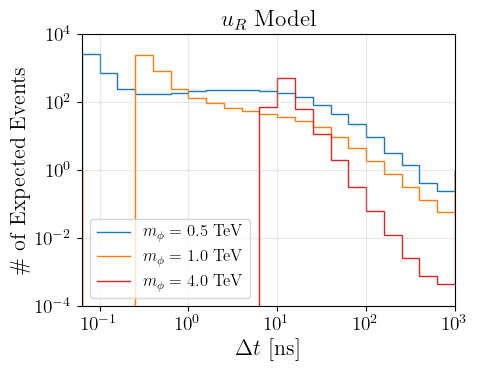

In [29]:
f_Δt = make_Δt_hist(runs_pdf, 10e6, [14,22,40]; log_binsize=0.2)
f_Δt.savefig(FIGDIR*"uR_delta_t_mip.pdf", bbox_inches="tight")
f_Δt